<a href="https://colab.research.google.com/github/claudiotancredi/mlinapptests/blob/main/BaselineRCGX12_unbalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022/DC03 Tool wear classification

### Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d4f8367e-c113-1011-b80f-ee45ef7132b9)


### Clone GitHub repo

In [2]:
!git clone https://github.com/claudiotancredi/Machine-learning-in-applications

Cloning into 'mlinapptests'...
remote: Enumerating objects: 656, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 656 (delta 34), reused 8 (delta 2), pack-reused 584
Receiving objects: 100% (656/656), 129.61 MiB | 21.25 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Checking out files: 100% (181/181), done.


### Install dependencies

In [3]:
!pip install -r /content/mlinapptests/src/models/Baseline_Mask_RCNN/colab-requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 8.2 MB/s 
     |████████████████████████████████| 411.0 MB 35 kB/s 
     |████████████████████████████████| 312 kB 59.1 MB/s 
     |████████████████████████████████| 2.9 MB 48.8 MB/s 
     |████████████████████████████████| 26.5 MB 1.4 MB/s 
     |████████████████████████████████| 503 kB 71.9 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 3.8 MB 49.6 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=b7a71328e4174c50c59ce24cac47a71aff236fce3b1ab33ccdf50b047b91cff5
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=20993bcddbe7b060b33a92f42a2804e97bf394419c69e7d8f33484853f367633
  Stored in directory: /root/.cache/p

In [ ]:
#Check dependencies
import tensorflow as tf
print(tf.__version__)

1.15.3


### Initialization

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/mlinapptests/src/models/Baseline_Mask_RCNN/maskrcnn")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 


# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


### Mount Drive
It is supposed to include a "2022-DC03" path with "images.zip" of ALL the images. The dataset folder of the repo includes the JSON file for annotations. Both annotations and images will be split automatically.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join("/content/drive/MyDrive/2022-DC03/Baseline", "logs")

### Prepare data on Drive
Install cocosplit requirements, prepare folders and images, split images.  
Mandatory only the first time, it's not necessary to run them if the dataset has already been split!  
The cell with copy_images may take a while to run, so don't worry (and don't interrupt the execution!).  

In [ ]:
!pip install -r /content/mlinapptests/src/cocosplit/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 4.2 MB/s 


In [ ]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Baseline_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import prepare_images_and_folder

prepare_images_and_folder(unpack=True)
#IMPORTANT
#If you're running the code for the first time and you unpack the .zip file, 
#this operation may take a while. Be sure not to have the annotations and images
#folders under "Baseline", so that when you see them you know that the unpacking has
#finished. 
#DO NOT RUN THE COPY OF IMAGES IF THE UNPACKING HAS NOT FINISHED YET!

Working in Baseline directory...
annotations folder didn't exist and has been created
images folder didn't exist and has been created
images/train folder didn't exist and has been created
images/val folder didn't exist and has been created
images/test folder didn't exist and has been created


In [ ]:
!python /content/mlinapptests/src/cocosplit/cocosplit.py --having-annotations -s 0.7 /content/mlinapptests/dataset/annot_v2_3classes_ok-with-empty-annot.json /content/drive/MyDrive/2022-DC03/Baseline/annotations/train.json /content/drive/MyDrive/2022-DC03/Baseline/annotations/test.json
# dataset folder contains all doubt and nok images for all components, and annotations.json from folder 1 of annotations

Saved 4960 entries in /content/drive/MyDrive/2022-DC03/Baseline/annotations/train.json and 2163 in /content/drive/MyDrive/2022-DC03/Baseline/annotations/test.json


In [ ]:
!python /content/mlinapptests/src/cocosplit/cocosplit.py --having-annotations -s 0.66 /content/drive/MyDrive/2022-DC03/Baseline/annotations/test.json /content/drive/MyDrive/2022-DC03/Baseline/annotations/test.json /content/drive/MyDrive/2022-DC03/Baseline/annotations/val.json

Saved 1431 entries in /content/drive/MyDrive/2022-DC03/Baseline/annotations/test.json and 732 in /content/drive/MyDrive/2022-DC03/Baseline/annotations/val.json


In [ ]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Baseline_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import copy_images

copy_images("train")
copy_images("val")
copy_images("test")

Number of images for  train :  3751
Number of images for  val :  548
Number of images for  test :  1061


### Dataset

In [4]:
tool = "RCGX12"

DS_DIR = os.path.abspath("/content/mlinapptests/dataset")

sys.path.append(DS_DIR)

from WearDataset import WearDataset

# Root directory of images and annotations
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/2022-DC03/Baseline/")

# Training dataset
dataset_train = WearDataset()
dataset_train.load_wear(ROOT_DIR, "train", tool=tool)
dataset_train.prepare()

# Validation dataset
dataset_val = WearDataset()
dataset_val.load_wear(ROOT_DIR, "val", tool=tool)
dataset_val.prepare()

# Test dataset
dataset_test = WearDataset()
dataset_test.load_wear(ROOT_DIR, "test", tool=tool)
dataset_test.prepare()
augmentation = imgaug.augmenters.Sequential([imgaug.augmenters.Fliplr(0.5), imgaug.augmenters.Flipud(0.5), imgaug.augmenters.Affine(rotate=[0,90])])

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Number of nok:  164
Number of doubt:  158
Number of ok without cut because balanced=False:  2024
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Number of nok:  35
Number of doubt:  17
Number of ok without cut because balanced=False:  310
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Number of nok:  56
Number of doubt:  50
Number of ok without cut because balanced=False:  561


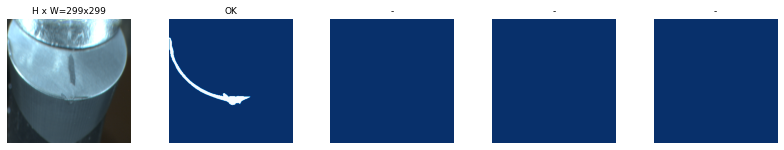

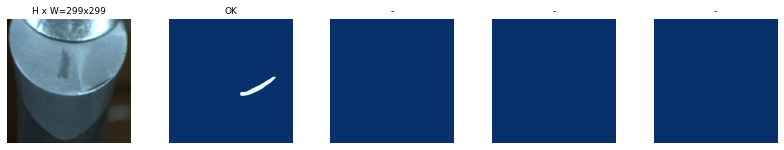

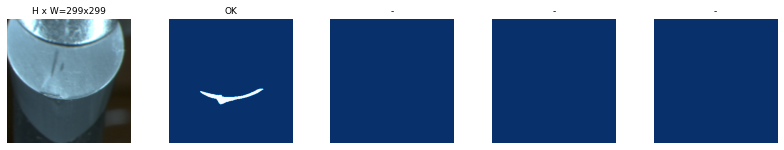

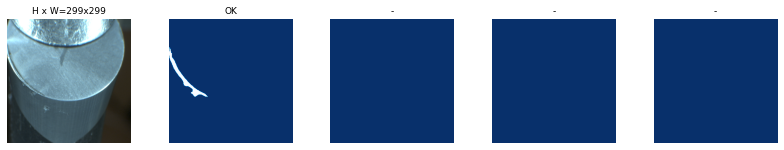

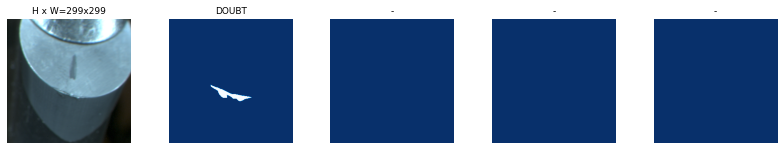

In [8]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Baseline_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_random_samples

visualize_random_samples(dataset_train, 5)

### Configurations

In [5]:
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/mlinapptests/src/models/Baseline_Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from wearconfig import WearConfig

class RCGX12Config(WearConfig):
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 587 # 2346 images /4 = 586.5
    
RCGX12config = RCGX12Config()
RCGX12config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### Create Model

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=RCGX12config,
                          model_dir=MODEL_DIR, tool=tool)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

### Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [12]:
%load_ext tensorboard

In [ ]:
import shutil
import glob

if os.path.exists("/content/drive/MyDrive/2022-DC03/Baseline/tblogs"):
  for match in glob.glob("/content/drive/MyDrive/2022-DC03/Baseline/tblogs/*"):
    shutil.rmtree(match)

In [13]:
# Training - Stage 1
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
import keras
import datetime
print("Training network heads")
logdir=os.path.join("/content/drive/MyDrive/2022-DC03/Baseline/tblogs", tool+"_3classes_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model.train(dataset_train, dataset_val, 
            learning_rate=RCGX12config.LEARNING_RATE, 
            epochs=100, 
            layers='heads',
            augmentation=augmentation,
            custom_callbacks=[keras.callbacks.TensorBoard(logdir, update_freq="epoch"), keras.callbacks.EarlyStopping(patience=20, verbose=1, restore_best_weights=True)])

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/2022-DC03/Baseline/logs/tool_wear_RCGX12_3classes_20220712T1310/mask_rcnn_tool_wear.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistribute

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/100
587/587 [==============================] - 259s 441ms/step - loss: 1.7869 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.7893 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.6252 - mrcnn_mask_loss: 0.2609 - val_loss: 3.0958 - val_rpn_class_loss: 0.0397 - val_rpn_bbox_loss: 2.0114 - val_mrcnn_class_loss: 0.0591 - val_mrcnn_bbox_loss: 0.6661 - val_mrcnn_mask_loss: 0.3195

Epoch 00001: val_loss improved from inf to 3.09575, saving model to /content/drive/MyDrive/2022-DC03/Baseline/logs/tool_wear_RCGX12_3classes_20220712T1310/mask_rcnn_tool_wear.h5

Epoch 2/100
587/587 [==============================] - 208s 355ms/step - loss: 1.6207 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.8279 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.5057 - mrcnn_mask_loss: 0.1970 - val_loss: 1.7556 - val_rpn_class_loss: 0.0231 - val_rpn_bbox_loss: 1.0091 - val_mrcnn_class_loss: 0.0589 - val_mrcnn_bbox_loss: 0.4709 - val_mrcnn_mask_loss: 0.1936

Epoch 00002: val_loss improved from 3.09575 to 1.75562,

In [14]:
# Training - Stage 3
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
import keras
import datetime
print("Fine tune all layers")
logdir=os.path.join("/content/drive/MyDrive/2022-DC03/Baseline/tblogs", tool+"_3classes_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model.load_weights(model.find_last(), by_name=True)
model.train(dataset_train, dataset_val, 
            learning_rate=RCGX12config.LEARNING_RATE / 10,
            epochs=250, #Training will resume from epoch 100, even if early stopping stopped the model on a previous epoch.
            # So it's as if the model sees the entire 100 epochs of training on the head branches. For this reason I used 250, so that
            # 150 more epochs will be done
            layers="all",
            augmentation=augmentation,
            custom_callbacks=[keras.callbacks.TensorBoard(logdir, update_freq="epoch"), keras.callbacks.EarlyStopping(patience=20, verbose=1, restore_best_weights=True)])
#patience should be around 10% of number of epochs

Fine tune all layers

Starting at epoch 47. LR=0.0001

Checkpoint Path: /content/drive/MyDrive/2022-DC03/Baseline/logs/tool_wear_RCGX12_3classes_20220712T1310/mask_rcnn_tool_wear.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multi

Epoch 48/250
587/587 [==============================] - 337s 574ms/step - loss: 1.0272 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5115 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.1384 - val_loss: 1.4234 - val_rpn_class_loss: 0.0188 - val_rpn_bbox_loss: 0.6860 - val_mrcnn_class_loss: 0.1745 - val_mrcnn_bbox_loss: 0.3720 - val_mrcnn_mask_loss: 0.1721

Epoch 00048: val_loss did not improve from 0.91153
Epoch 49/250
587/587 [==============================] - 280s 478ms/step - loss: 0.9390 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4405 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.2964 - mrcnn_mask_loss: 0.1373 - val_loss: 1.1477 - val_rpn_class_loss: 0.0144 - val_rpn_bbox_loss: 0.6718 - val_mrcnn_class_loss: 0.0436 - val_mrcnn_bbox_loss: 0.2932 - val_mrcnn_mask_loss: 0.1247

Epoch 00049: val_loss did not improve from 0.91153
Epoch 50/250
587/587 [==============================] - 280s 478ms/step - loss: 0.9844 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

In [15]:
%tensorboard --logdir /content/drive/MyDrive/2022-DC03/Baseline/tblogs

### Detection

In [6]:
class InferenceConfig(RCGX12Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

inference_config = InferenceConfig()
inference_config.display()

from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR, tool=tool)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
#CHANGE MODEL_PATH MANUALLY EVERY TIME PLEASE

# Load trained weights
print("Loading weights from ", model_path)

model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

#### Visualize ground truth

Image name:  RCGX12_GMTK1_20211021_006604_wo_cn.bmp
original_image           shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  320.00000  float64
gt_class_id              shape: (2,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (2, 4)                min:    3.00000  max:  209.00000  int32
gt_mask                  shape: (320, 320, 2)         min:    0.00000  max:    1.00000  bool


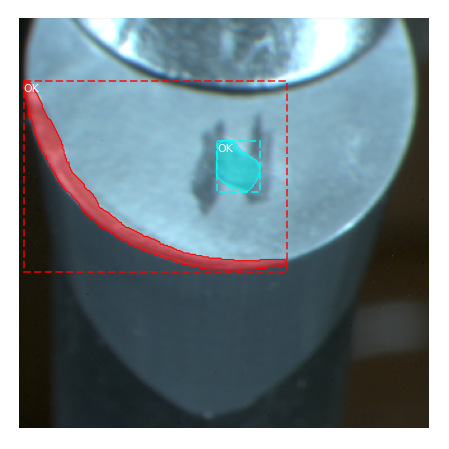

In [7]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Baseline_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_gt

image_id = visualize_gt(dataset_test, inference_config, 3)

#### Visualize predictions

Image name:  RCGX12_GMTK1_20211021_006604_wo_cn.bmp
Processing 1 images
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


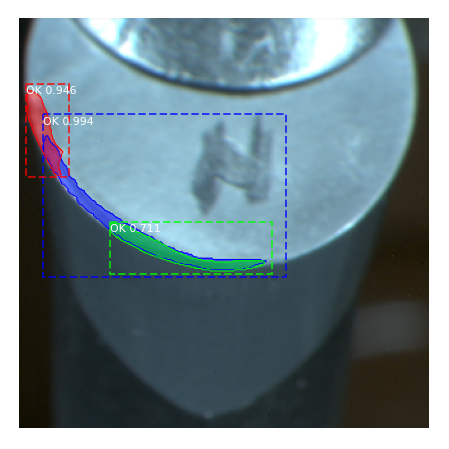

In [8]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Baseline_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_pred

visualize_pred(dataset_test, inference_config, image_id, model)

## Evaluation

In [9]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Baseline_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import compute_map

compute_map(dataset_test, inference_config, model)

mAP: 0.692


In [10]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Baseline_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import compute_accuracy

compute_accuracy(dataset_test, inference_config, model)

label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wn  but predicted label is:  wo
label_gt is:  wn  but predicted label is:  wo
label_gt is:  wn  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wn  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wn  but predicted label is:  wo
label_gt is:  wn  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted label is:  wo
label_gt is:  wd  but predicted la